# Neural Network - Generalization

In [1]:
# Python imports
import numpy as np # Matrix and vector computation package
import matplotlib.pyplot as plt  # Plotting library
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator so that the tutorial is reproducable
np.random.seed(seed=1)
from sklearn import datasets, cross_validation, metrics # data and evaluation utils
from matplotlib.colors import colorConverter, ListedColormap # some plotting functions
import itertools
import collections

In [2]:
# load the data from scikit-learn.
digits = datasets.load_digits()

# Load the targets.
# Note that the targets are stored as digits, these need to be 
#  converted to one-hot-encoding for the output sofmax layer.
T = np.zeros((digits.target.shape[0],10))
T[np.arange(len(T)), digits.target] += 1

# Divide the data into a train and test set.
X_train, X_test, T_train, T_test = cross_validation.train_test_split(
    digits.data, T, test_size=0.4)
# Divide the test set into a validation set and final test set.
X_validation, X_test, T_validation, T_test = cross_validation.train_test_split(
    X_test, T_test, test_size=0.5)

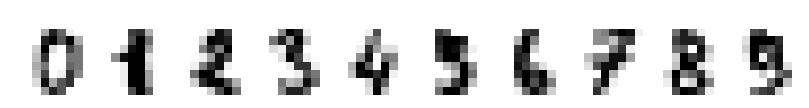

In [3]:
# Plot an example of each image.
fig = plt.figure(figsize=(10, 1), dpi=100)
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    ax.matshow(digits.images[i], cmap='binary') 
    ax.axis('off')
plt.show()

In [4]:
# Define the non-linear functions used
def logistic(z): 
    return 1 / (1 + np.exp(-z))

def logistic_deriv(y):  # Derivative of logistic function
    return np.multiply(y, (1 - y))
    
def softmax(z): 
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

In [5]:
# Define the layers used in this model
class Layer(object):
    """Base class for the different layers.
    Defines base methods and documentation of methods."""
    
    def get_params_iter(self):
        """Return an iterator over the parameters (if any).
        The iterator has the same order as get_params_grad.
        The elements returned by the iterator are editable in-place."""
        return []
    
    def get_params_grad(self, X, output_grad):
        """Return a list of gradients over the parameters.
        The list has the same order as the get_params_iter iterator.
        X is the input.
        output_grad is the gradient at the output of this layer.
        """
        return []
    
    def get_output(self, X):
        """Perform the forward step linear transformation.
        X is the input."""
        pass
    
    def get_input_grad(self, Y, output_grad=None, T=None):
        """Return the gradient at the inputs of this layer.
        Y is the pre-computed output of this layer (not needed in this case).
        output_grad is the gradient at the output of this layer 
         (gradient at input of next layer).
        Output layer uses targets T to compute the gradient based on the 
         output error instead of output_grad"""
        pass

In [6]:
class LinearLayer(Layer):
    """The linear layer performs a linear transformation to its input."""
    
    def __init__(self, n_in, n_out):
        """Initialize hidden layer parameters.
        n_in is the number of input variables.
        n_out is the number of output variables."""
        self.W = np.random.randn(n_in, n_out) * 0.1
        self.b = np.zeros(n_out)
        
    def get_params_iter(self):
        """Return an iterator over the parameters."""
        return itertools.chain(np.nditer(self.W, op_flags=['readwrite']),
                               np.nditer(self.b, op_flags=['readwrite']))
    
    def get_output(self, X):
        """Perform the forward step linear transformation."""
        return X.dot(self.W) + self.b
        
    def get_params_grad(self, X, output_grad):
        """Return a list of gradients over the parameters."""
        JW = X.T.dot(output_grad)
        Jb = np.sum(output_grad, axis=0)
        return [g for g in itertools.chain(np.nditer(JW), np.nditer(Jb))]
    
    def get_input_grad(self, Y, output_grad):
        """Return the gradient at the inputs of this layer."""
        return output_grad.dot(self.W.T)

In [7]:
class LogisticLayer(Layer):
    """The logistic layer applies the logistic function to its inputs."""
    
    def get_output(self, X):
        """Perform the forward step transformation."""
        return logistic(X)
    
    def get_input_grad(self, Y, output_grad):
        """Return the gradient at the inputs of this layer."""
        return np.multiply(logistic_deriv(Y), output_grad)

In [8]:
class SoftmaxOutputLayer(Layer):
    """The softmax output layer computes the classification propabilities at the output."""
    
    def get_output(self, X):
        """Perform the forward step transformation."""
        return softmax(X)
    
    def get_input_grad(self, Y, T):
        """Return the gradient at the inputs of this layer."""
        return (Y - T) / Y.shape[0]
    
    def get_cost(self, Y, T):
        """Return the cost at the output of this output layer."""
        return - np.multiply(T, np.log(Y)).sum() / Y.shape[0]

In [9]:
# Define a sample model to be trained on the data
hidden_neurons_1 = 20  # Number of neurons in the first hidden-layer
hidden_neurons_2 = 20  # Number of neurons in the second hidden-layer
# Create the model
layers = [] # Define a list of layers
# Add first hidden layer
layers.append(LinearLayer(X_train.shape[1], hidden_neurons_1))
layers.append(LogisticLayer())
# Add second hidden layer
layers.append(LinearLayer(hidden_neurons_1, hidden_neurons_2))
layers.append(LogisticLayer())
# Add output layer
layers.append(LinearLayer(hidden_neurons_2, T_train.shape[1]))
layers.append(SoftmaxOutputLayer())

In [10]:
# Define the forward propagation step as a method.
def forward_step(input_samples, layers):
    """
    Compute and return the forward activation of each layer in layers.
    Input:
        input_samples: A matrix of input samples (each row is an input vector)
        layers: A list of Layers
    Output:
        A list of activations where the activation at each index i+1 corresponds to
        the activation of layer i in layers. activations[0] contains the input samples.  
    """
    activations = [input_samples] # List of layer activations
    # Compute the forward activations for each layer starting from the first
    X = input_samples
    for layer in layers:
        Y = layer.get_output(X)  # Get the output of the current layer
        activations.append(Y)  # Store the output for future processing
        X = activations[-1]  # Set the current input as the activations of the previous layer
    return activations  # Return the activations of each layer

In [11]:
# Define the backward propagation step as a method
def backward_step(activations, targets, layers):
    """
    Perform the backpropagation step over all the layers and return the parameter gradients.
    Input:
        activations: A list of forward step activations where the activation at 
            each index i+1 corresponds to the activation of layer i in layers. 
            activations[0] contains the input samples. 
        targets: The output targets of the output layer.
        layers: A list of Layers corresponding that generated the outputs in activations.
    Output:
        A list of parameter gradients where the gradients at each index corresponds to
        the parameters gradients of the layer at the same index in layers. 
    """
    param_grads = collections.deque()  # List of parameter gradients for each layer
    output_grad = None  # The error gradient at the output of the current layer
    # Propagate the error backwards through all the layers.
    #  Use reversed to iterate backwards over the list of layers.
    for layer in reversed(layers):   
        Y = activations.pop()  # Get the activations of the last layer on the stack
        # Compute the error at the output layer.
        # The output layer error is calculated different then hidden layer error.
        if output_grad is None:
            input_grad = layer.get_input_grad(Y, targets)
        else:  # output_grad is not None (layer is not output layer)
            input_grad = layer.get_input_grad(Y, output_grad)
        # Get the input of this layer (activations of the previous layer)
        X = activations[-1]
        # Compute the layer parameter gradients used to update the parameters
        grads = layer.get_params_grad(X, output_grad)
        param_grads.appendleft(grads)
        # Compute gradient at output of previous layer (input of current layer):
        output_grad = input_grad
    return list(param_grads)  # Return the parameter gradients

In [12]:
# Perform gradient checking
nb_samples_gradientcheck = 10 # Test the gradients on a subset of the data
X_temp = X_train[0:nb_samples_gradientcheck,:]
T_temp = T_train[0:nb_samples_gradientcheck,:]
# Get the parameter gradients with backpropagation
activations = forward_step(X_temp, layers)
param_grads = backward_step(activations, T_temp, layers)

# Set the small change to compute the numerical gradient
eps = 0.0001
# Compute the numerical gradients of the parameters in all layers.
for idx in range(len(layers)):
    layer = layers[idx]
    layer_backprop_grads = param_grads[idx]
    # Compute the numerical gradient for each parameter in the layer
    for p_idx, param in enumerate(layer.get_params_iter()):
        grad_backprop = layer_backprop_grads[p_idx]
        # + eps
        param += eps
        plus_cost = layers[-1].get_cost(forward_step(X_temp, layers)[-1], T_temp)
        # - eps
        param -= 2 * eps
        min_cost = layers[-1].get_cost(forward_step(X_temp, layers)[-1], T_temp)
        # reset param value
        param += eps
        # calculate numerical gradient
        grad_num = (plus_cost - min_cost)/(2*eps)
        # Raise error if the numerical grade is not close to the backprop gradient
        if not np.isclose(grad_num, grad_backprop):
            raise ValueError('Numerical gradient of {:.6f} is not close to the backpropagation gradient of {:.6f}!'.format(float(grad_num), float(grad_backprop)))
print('No gradient errors found')

No gradient errors found


In [13]:
# Create the minibatches
batch_size = 25  # Approximately 25 samples per batch
nb_of_batches = X_train.shape[0] / batch_size  # Number of batches
# Create batches (X,Y) from the training set
XT_batches = zip(
    np.array_split(X_train, nb_of_batches, axis=0),  # X samples
    np.array_split(T_train, nb_of_batches, axis=0))  # Y targets

In [19]:
# Define a method to update the parameters
def update_params(layers, param_grads, learning_rate):
    """
    Function to update the parameters of the given layers with the given gradients
    by gradient descent with the given learning rate.
    """
    for layer, layer_backprop_grads in zip(layers, param_grads):
        for param, grad in zip(layer.get_params_iter(), layer_backprop_grads):
            # The parameter returned by the iterator point to the memory space of
            #  the original layer and can thus be modified inplace.
            param -= learning_rate * grad  # Update each parameter

In [20]:
# Perform backpropagation
# initalize some lists to store the cost for future analysis        
minibatch_costs = []
training_costs = []
validation_costs = []

max_nb_of_iterations = 300  # Train for a maximum of 300 iterations
learning_rate = 0.1  # Gradient descent learning rate

# Train for the maximum number of iterations
for iteration in range(max_nb_of_iterations):
    for X, T in XT_batches:  # For each minibatch sub-iteration
        activations = forward_step(X, layers)  # Get the activations
        minibatch_cost = layers[-1].get_cost(activations[-1], T)  # Get cost
        minibatch_costs.append(minibatch_cost)
        param_grads = backward_step(activations, T, layers)  # Get the gradients
        update_params(layers, param_grads, learning_rate)  # Update the parameters
    # Get full training cost for future analysis (plots)
    activations = forward_step(X_train, layers)
    train_cost = layers[-1].get_cost(activations[-1], T_train)
    training_costs.append(train_cost)
    # Get full validation cost
    activations = forward_step(X_validation, layers)
    validation_cost = layers[-1].get_cost(activations[-1], T_validation)
    validation_costs.append(validation_cost)
    if len(validation_costs) > 3:
        # Stop training if the cost on the validation set doesn't decrease
        #  for 3 iterations
        if validation_costs[-1] >= validation_costs[-2] >= validation_costs[-3]:
            break
    
nb_of_iterations = iteration + 1  # The number of iterations that have been executed

ValueError: x and y must have same first dimension

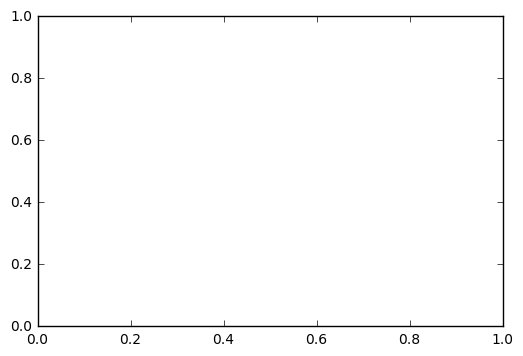

In [21]:
# Plot the minibatch, full training set, and validation costs
minibatch_x_inds = np.linspace(0, nb_of_iterations, num=nb_of_iterations*nb_of_batches)
iteration_x_inds = np.linspace(1, nb_of_iterations, num=nb_of_iterations)
# Plot the cost over the iterations
plt.plot(minibatch_x_inds, minibatch_costs, 'k-', linewidth=0.5, label='cost minibatches')
plt.plot(iteration_x_inds, training_costs, 'r-', linewidth=2, label='cost full training set')
plt.plot(iteration_x_inds, validation_costs, 'b-', linewidth=3, label='cost validation set')
# Add labels to the plot
plt.xlabel('iteration')
plt.ylabel('$\\xi$', fontsize=15)
plt.title('Decrease of cost over backprop iteration')
plt.legend()
x1,x2,y1,y2 = plt.axis()
plt.axis((0,nb_of_iterations,0,2.5))
plt.grid()
plt.show()

In [22]:
# Get results of test data
y_true = np.argmax(T_test, axis=1)  # Get the target outputs
activations = forward_step(X_test, layers)  # Get activation of test samples
y_pred = np.argmax(activations[-1], axis=1)  # Get the predictions made by the network
test_accuracy = metrics.accuracy_score(y_true, y_pred)  # Test set accuracy
print('The accuracy on the test set is {:.2f}'.format(test_accuracy))

The accuracy on the test set is 0.37


In [ ]:
# Show confusion table
conf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=None)  # Get confustion matrix
# Plot the confusion table
class_names = ['${:d}$'.format(x) for x in range(0, 10)]  # Digit class names
fig = plt.figure()
ax = fig.add_subplot(111)
# Show class labels on each axis
ax.xaxis.tick_top()
major_ticks = range(0,10)
minor_ticks = [x + 0.5 for x in range(0, 10)]
ax.xaxis.set_ticks(major_ticks, minor=False)
ax.yaxis.set_ticks(major_ticks, minor=False)
ax.xaxis.set_ticks(minor_ticks, minor=True)
ax.yaxis.set_ticks(minor_ticks, minor=True)
ax.xaxis.set_ticklabels(class_names, minor=False, fontsize=15)
ax.yaxis.set_ticklabels(class_names, minor=False, fontsize=15)
# Set plot labels
ax.yaxis.set_label_position("right")
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
fig.suptitle('Confusion table', y=1.03, fontsize=15)
# Show a grid to seperate digits
ax.grid(b=True, which=u'minor')
# Color each grid cell according to the number classes predicted
ax.imshow(conf_matrix, interpolation='nearest', cmap='binary')
# Show the number of samples in each cell
for x in xrange(conf_matrix.shape[0]):
    for y in xrange(conf_matrix.shape[1]):
        color = 'w' if x == y else 'k'
        ax.text(x, y, conf_matrix[y,x], ha="center", va="center", color=color)       
plt.show()